Feature Extraction

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import glob
import cv2

%matplotlib inline
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


#The input format of images has to be RGB
def extract_feature(img, color_space, spatial_size=(32, 32),
                    hist_bins=32, bins_range=(0, 256), orient=9,pix_per_cell=8,cell_per_block=2, 
                    hog_channel=0):    

    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 

    spatial_features = bin_spatial(feature_image, spatial_size)
    img_features.append(spatial_features)

    hist_features = color_hist(feature_image, hist_bins, bins_range )
    img_features.append(hist_features)

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))      
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    img_features.append(hog_features)
    return np.concatenate(img_features)



Extracting Features From Files

In [2]:
def extract_features_from_files(img_files, color_space='RGB', spatial_size=(32, 32),hist_bins=32, bins_range=(0, 256), orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in img_files:
        feas = []
        image_bgr = cv2.imread(file) 
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        feas = extract_feature(image,color_space,spatial_size,
                                hist_bins, bins_range, orient, pix_per_cell, cell_per_block,
                                hog_channel)
        features.append(feas)
        
        image=cv2.flip(image,1) 
        feas = extract_feature(image,color_space,spatial_size,
                                hist_bins, bins_range, orient, pix_per_cell, cell_per_block,
                                hog_channel)
        features.append(feas)
        
    print ('features extracted from files')    
    return features

Classifier and Training

In [3]:
cars=[]
notcars=[]
cars = glob.iglob('data/vehicles/**/*.png')
notcars = glob.iglob('data/non-vehicles/**/*.png')

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins


print("Extracting car_features")
car_features = extract_features_from_files(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print("Extracting notcar_features")
notcar_features = extract_features_from_files(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X) 

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) 


X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Feature :', len(X_train[0]))
svc = LinearSVC(loss='hinge') 

svc.fit(X_train, y_train) 
print('Test Accuracy ', round(svc.score(X_test, y_test), 4))




Extracting car_features
features extracted from files
Extracting notcar_features
features extracted from files
Feature : 6108
Test Accuracy  0.9913


Sliding Windows

In [4]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    img_new = np.copy(img) 
    for bbox in bboxes: 
        cv2.rectangle(img_new, bbox[0], bbox[1], color, thick)
    return img_new

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, threshold=1.2, debug = False):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = extract_feature(test_img, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        # prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        confidence = clf.decision_function(test_features)
        if confidence >= threshold:
            on_windows.append(window)
            if debug : print("Classifier confidence: ", confidence)
    #8) Return windows for positive detections
    return on_windows

def show_image(img):
    #img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [5]:
images = []
for file in glob.glob('test_images/test*.jpg'):
    image_bgr = cv2.imread(file)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    images.append(image)

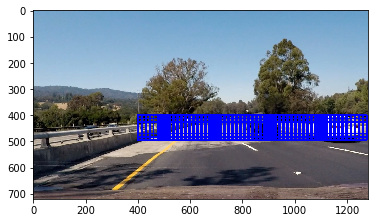

In [6]:
windows_far = slide_window(images[0], x_start_stop=[400, 1280], y_start_stop=[400, 500], 
                xy_window=(80, 70), xy_overlap=(0.8, 0.8))
window_img = draw_boxes(image, windows_far, color=(0, 0, 255), thick=6) 
show_image(window_img)



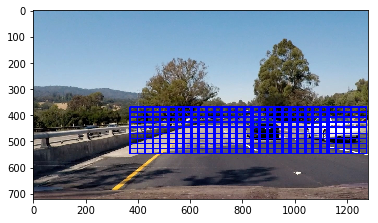

In [7]:
windows_mid_far = slide_window(images[0], x_start_stop=[370, 1280], y_start_stop=[370, 550], 
                xy_window=(150, 100), xy_overlap=(0.8, 0.8))
window_img = draw_boxes(image, windows_mid_far, color=(0, 0, 255), thick=6) 
show_image(window_img)

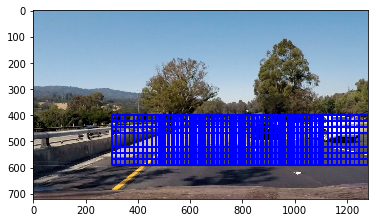

In [8]:
windows_mid = slide_window(images[0], x_start_stop=[300, 1280], y_start_stop=[400, 600], 
                xy_window=(180, 120), xy_overlap=(0.9, 0.8))
window_img = draw_boxes(image, windows_mid, color=(0, 0, 255), thick=6) 
show_image(window_img)

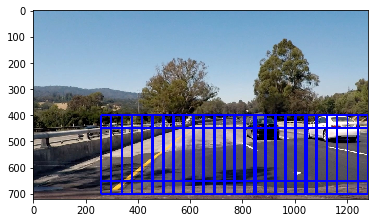

In [9]:


windows_close = slide_window(images[0], x_start_stop=[260, 1280], y_start_stop=[400, None], 
                xy_window=(200, 250), xy_overlap=(0.8, 0.8))
window_img = draw_boxes(image, windows_close, color=(0, 0, 255), thick=6) 
show_image(window_img)



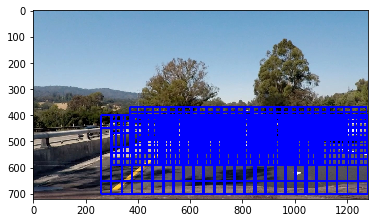

In [10]:
windows = windows_far + windows_mid_far+ windows_mid + windows_close
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
show_image(window_img)

Evaluating the Classifier

Classifier confidence:  [ 2.06298049]
Classifier confidence:  [ 2.57511409]
Classifier confidence:  [ 3.10201877]
Classifier confidence:  [ 2.46177921]
Classifier confidence:  [ 3.21918284]
Classifier confidence:  [ 1.88532478]
Classifier confidence:  [ 3.79881152]
Classifier confidence:  [ 2.91430508]
Classifier confidence:  [ 2.68732813]
Classifier confidence:  [ 4.03206549]
Classifier confidence:  [ 1.71014054]
Classifier confidence:  [ 2.58487325]
Classifier confidence:  [ 2.5133538]


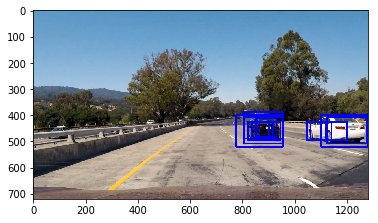

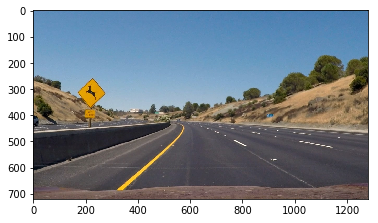

Classifier confidence:  [ 1.83694984]
Classifier confidence:  [ 2.4643345]
Classifier confidence:  [ 1.9148185]
Classifier confidence:  [ 3.6719137]
Classifier confidence:  [ 1.70453062]
Classifier confidence:  [ 1.92693668]
Classifier confidence:  [ 2.52693981]
Classifier confidence:  [ 2.57913918]
Classifier confidence:  [ 2.00513028]
Classifier confidence:  [ 2.46099482]


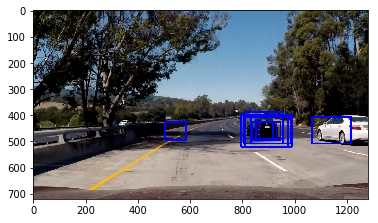

Classifier confidence:  [ 2.70766913]


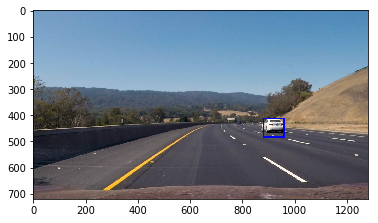

Classifier confidence:  [ 1.95124649]
Classifier confidence:  [ 2.0207576]
Classifier confidence:  [ 1.84654699]
Classifier confidence:  [ 1.70527901]
Classifier confidence:  [ 3.12727963]
Classifier confidence:  [ 1.94408089]


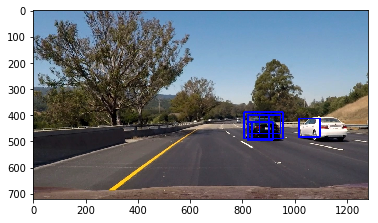

Classifier confidence:  [ 1.7302063]
Classifier confidence:  [ 3.78878439]
Classifier confidence:  [ 1.80026559]
Classifier confidence:  [ 2.01149175]
Classifier confidence:  [ 1.88473938]
Classifier confidence:  [ 2.58718078]


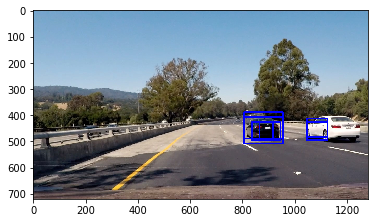

In [11]:


for image in images:
    draw_image = np.copy(image)
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,threshold=1.7,debug=True))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)    
    show_image(window_img)



Multiple Detections & False Positives

In [12]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)

    return img
    
from scipy.ndimage.measurements import label

def find_cars(input_image, windows, classifier, scaler, draw=True):
    global bboxes_list
    
    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,threshold=1.7)
    bboxes_list.append(hot_windows)
    
def add_bboxes_to_list(image):
    return add_bboxes(image, windows, svc, X_scaler)


def add_heat(heatmap, box_list):
    for box in box_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

#def create_heatmaps(all_bboxes, recent_frames_used=20, threshold=5):
#    heatmap_list = []
#
#    for idx, boxlist in enumerate(all_bboxes):
#        idx_start = max(idx - recent_frames_used, 0)
#        idx_heatmap = heatmap_template
#        for boxlist2 in all_bboxes[idx_start:idx + 1]:
#            idx_heatmap = add_heat(idx_heatmap, boxlist2)

#        idx_heatmap[idx_heatmap <= threshold] = 0
#        heatmap_list.append(idx_heatmap)
#        plt.imshow(idx_heatmap, cmap="hot")

#    return heatmap_list



Pipeline

In [13]:
def pipeline(image):
    global bboxes_list
    global heat_map_g
    recent_frames_used=15
    threshold_hm=10
    
    image_test = cv2.GaussianBlur(image, (15, 15), 0)
    find_cars(image_test, windows, svc, X_scaler, draw=False)
    
    # Adjust parameters if needed
    if len(bboxes_list) < recent_frames_used + 1:
        recent_frames_used = len(bboxes_list) - 1    
    
    frame_heatmap = np.zeros_like(image[:,:,0])
    for boxlist in bboxes_list[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    heat_map_g = frame_heatmap.copy()
    # Apply threshold
    frame_heatmap[frame_heatmap <= threshold_hm] = 0
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

#def pipeline_resized(img):
#    result = pipeline(img)
#    return cv2.resize(result, (320, 180))

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []
heat_map_g = None
video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(pipeline)
video_output = "project_video_output.mp4"
%time project_clip.write_videofile(video_output, audio=False)
plt.imshow(heat_map_g,cmap="hot")
plt.show()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 46%|████▌     | 579/1261 [7:51:27<25:54,  2.28s/it]       